In [441]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import random



In [442]:
dfs = [[] for _ in range(10)]
for i in range(10):
    for k in range(100):
        df = pd.read_csv(f"../training_data/stroke_{i}_{k+1:04}.csv", header=None)
        df.drop(df.columns[2], axis=1, inplace=True)
        # df = (df - df.min()) / (df.max()-df.min())
        df = (df - df.mean()) / (df.std())
        dfs[i].append(df)


In [443]:
train_data = []
test_data = []
for num in range(10):
    train, test = train_test_split(dfs[num], test_size=0.25)
    train_data.append(train)
    test_data.append(test)


In [444]:
LINE_BINS = 12
ANGLE_BINS = 12
BINS = LINE_BINS + ANGLE_BINS

def bucketize(x, num_buckets, range):
    res = int((x - range[0]) / (range[1] - range[0]) * num_buckets)
    if res == num_buckets:
        res -= 1
    return res
    
def featurize_point_vector(df: pd.DataFrame):
    features = []
    buckets = np.zeros((ANGLE_BINS))
    for i in range(df.shape[0]-1):
        angle = np.arctan2(df.iloc[i, 1], df.iloc[i, 0])
        bucket = bucketize(angle, ANGLE_BINS, (-np.pi, np.pi))
        magnitude = np.linalg.norm(df.iloc[i])
        buckets[bucket] += magnitude

    # res = np.histogram(features, bins=ANGLE_BINS, range=(-np.pi, np.pi))[0]
    res = buckets / buckets.sum()
    return res

def featurize_lines(df: pd.DataFrame):
    features = []
    buckets = np.zeros((LINE_BINS))

    for i in range(df.shape[0]-1):
        dir = df.iloc[i+1] - df.iloc[i]
        angle = np.arctan2(dir.iloc[1], dir.iloc[0])

        bucket = bucketize(angle, LINE_BINS, (-np.pi, np.pi))
        magnitude = np.linalg.norm(dir)
        buckets[bucket] += magnitude

    # res = np.histogram(features, bins=LINE_BINS, range=(-np.pi, np.pi))[0]
    # res = res / res.sum()
    res = buckets / buckets.sum()

    return res

def featurize(df: pd.DataFrame):
    angle_features = featurize_point_vector(df)
    line_features = featurize_lines(df)
    # line_features = []
    res = np.concatenate((line_features, angle_features))
    return res


In [445]:
num_clusters = [
    2,  # 0
    4,  # 1
    3,  # 2
    2,  # 3
    2,  # 4
    2,  # 5
    2,  # 6
    3,  # 7
    2,  # 8
    2,  # 9
]

cluster_mapping = [i for i in range(10) for _ in range(num_clusters[i])]
print(cluster_mapping)


[0, 0, 1, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 7, 8, 8, 9, 9]


In [446]:
fvs = []

for num in range(10):
    features = []
    for df in train_data[num]:
        features.append(featurize(df))

    km = KMeans(n_clusters=num_clusters[num], n_init=20)
    km.fit(features)
    fvs += km.cluster_centers_.tolist()
    for i in range(num_clusters[num]):
        print(f"Num: {num},Cluster {i}: {km.labels_.tolist().count(i)}")
        # plt.bar(range(ANGLE_BINS), km.cluster_centers_[i])
        # plt.title(f"{num} {i}")
        # plt.show()
    # fvs.append(km.cluster_centers_[0])
    # fvs.append(km.cluster_centers_[1])
    # plt.bar(range(BINS), avg)
    # plt.title(str(num))
    # plt.show()



Num: 0,Cluster 0: 50
Num: 0,Cluster 1: 25
Num: 1,Cluster 0: 28
Num: 1,Cluster 1: 33
Num: 1,Cluster 2: 11
Num: 1,Cluster 3: 3
Num: 2,Cluster 0: 19
Num: 2,Cluster 1: 27
Num: 2,Cluster 2: 29
Num: 3,Cluster 0: 21
Num: 3,Cluster 1: 54
Num: 4,Cluster 0: 58
Num: 4,Cluster 1: 17
Num: 5,Cluster 0: 18
Num: 5,Cluster 1: 57
Num: 6,Cluster 0: 37
Num: 6,Cluster 1: 38
Num: 7,Cluster 0: 34
Num: 7,Cluster 1: 18
Num: 7,Cluster 2: 23
Num: 8,Cluster 0: 48
Num: 8,Cluster 1: 27
Num: 9,Cluster 0: 22
Num: 9,Cluster 1: 53


In [447]:
from scipy.stats import chisquare
from scipy.special import kl_div
correct = 0
incorrect = 0

y_true = []
y_pred = []

for num in range(10):
    nc = 0
    ni = 0
    for df in test_data[num]:
        test_features = featurize(df)

        scores = []
        for ti, template in enumerate(fvs):
            # score = chisquare(tmp, template)
            score = np.sum(kl_div(test_features, template))
            # scores.append(score.pvalue)
            scores.append(score)

        selected = cluster_mapping[np.argmin(scores)]
        # selected = np.argmax(scores)//2
        # print(f"i: {i}, Num: {num}, Estimate: {selected}")
        y_true.append(num)
        y_pred.append(selected)

        if selected == num:
            correct += 1
            nc += 1
        else:
            incorrect += 1
            ni += 1

    print(f"Num: {num}, Correct: {nc}, Incorrect: {ni}, Accuracy: {nc/(nc+ni)}")
print(f"Correct: {correct}, Incorrect: {incorrect}, Accuracy: {correct/(correct+incorrect)}")


Num: 0, Correct: 24, Incorrect: 1, Accuracy: 0.96
Num: 1, Correct: 19, Incorrect: 6, Accuracy: 0.76
Num: 2, Correct: 25, Incorrect: 0, Accuracy: 1.0
Num: 3, Correct: 24, Incorrect: 1, Accuracy: 0.96
Num: 4, Correct: 22, Incorrect: 3, Accuracy: 0.88
Num: 5, Correct: 24, Incorrect: 1, Accuracy: 0.96
Num: 6, Correct: 24, Incorrect: 1, Accuracy: 0.96
Num: 7, Correct: 24, Incorrect: 1, Accuracy: 0.96
Num: 8, Correct: 23, Incorrect: 2, Accuracy: 0.92
Num: 9, Correct: 22, Incorrect: 3, Accuracy: 0.88
Correct: 231, Incorrect: 19, Accuracy: 0.924


In [448]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_true, y_pred)


array([[24,  0,  0,  0,  0,  0,  1,  0,  0,  0],
       [ 0, 19,  1,  2,  0,  0,  0,  2,  0,  1],
       [ 0,  0, 25,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0, 24,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0, 22,  0,  1,  1,  0,  0],
       [ 0,  0,  0,  1,  0, 24,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1, 24,  0,  0,  0],
       [ 0,  1,  0,  0,  0,  0,  0, 24,  0,  0],
       [ 2,  0,  0,  0,  0,  0,  0,  0, 23,  0],
       [ 0,  0,  0,  3,  0,  0,  0,  0,  0, 22]])

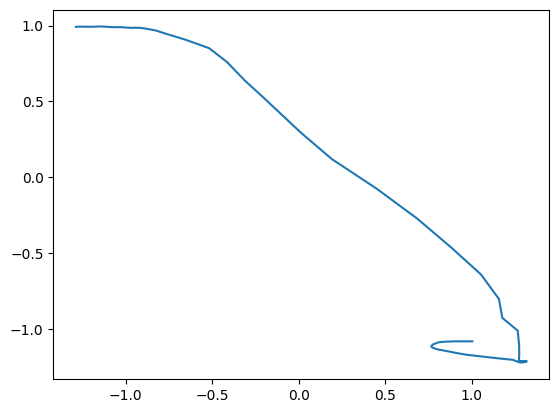

In [449]:
num = 1
i = 90
plt.plot(dfs[num][i].iloc[:,0], dfs[num][i].iloc[:,1])
